## UCL COMP0029 Individual Project for Year 3 BSc
### Robust Robotic Grasping Utilising Touch Sensing - Baseline Approach Notebook
This notebook contains the essential code for training and testing a supervised baseline approach to grasping. Given some tactile data, end effector poses, etc., it determines whether these constraints will produce a successful/unsuccessful grasp.

### 1. Load packages

In [1027]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import gc

Z_PADDING = 0.15

Set device for `PyTorch` training

In [1028]:
# Use GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Empty PyTorch cache

In [1029]:
gc.collect()
torch.cuda.empty_cache()

### 2. Load datasets

Two datasets have been prepared from running the "collect sensory data" in the Pybullet simulation. These datasets are:
- `poses_ds.npy` that stores random 6d end effector poses generated by applying gaussian noise a manually selected base pose
- `training_ds.npy` that stores the tactile reading data collected from the DIGIT tactile sensors in the Pybullet simulation

The collected datasets are stored in `np.ndarray`s in a `.npy` file.

In [1030]:
object_name = "block"

depth_ds_file_path = object_name + "_ds/depth_ds.npy"
depth_ds = np.load(depth_ds_file_path)
print(f"Shape of depth_ds: {depth_ds.shape}")

color_ds_file_path = object_name + "_ds/color_ds.npy"
color_ds = np.load(color_ds_file_path)
print(f"Shape of color_ds: {color_ds.shape}")

poses_ds_file_path = object_name + "_ds/poses_ds.npy"
poses_ds = np.load(poses_ds_file_path)
print(f"Shape of poses_ds: {poses_ds.shape}")

grasp_outcomes_ds_file_path = object_name + "_ds/grasp_outcomes.npy"
grasp_outcomes_ds = np.load(grasp_outcomes_ds_file_path)
print(f"Shape of grasp_outcomes_ds: {grasp_outcomes_ds.shape}")

Shape of depth_ds: (315, 2, 160, 120)
Shape of color_ds: (315, 2, 160, 120, 3)
Shape of poses_ds: (315, 6)
Shape of grasp_outcomes_ds: (315,)


In [1031]:
### Check the number of successes and failures in the dataset
success = 0
failure = 0

for row in grasp_outcomes_ds:
    if row == 1:
        success += 1
    elif row == 0:
        failure += 1

print(f"Successes: {success} | Failures: {failure}")

Successes: 125 | Failures: 190


### 3. Creating trainable dataset

We can treat the depth and color images of each finger's sensor as separate or concatenated images. In this notebook, we will simply use the images separately. We will also sample 500 examples from each class label (successful and unsuccessful grasps) to reduce the computational cost.

#### Sampling
We sample 500 successful and 500 unsuccessful grasps.

In [1032]:
def sample_data(depth_ds, color_ds, poses_ds, outcomes_ds, no_of_examples):
    selected_depth_ds = []
    selected_color_ds = []
    selected_poses_ds = []
    selected_outcomes_ds = []

    selected_classes = set()

    depth_ds = torch.from_numpy(depth_ds)
    color_ds = torch.from_numpy(color_ds)
    poses_ds = torch.from_numpy(poses_ds)
    outcomes_ds = torch.from_numpy(outcomes_ds)

    for label in torch.unique(outcomes_ds):
        class_indices = (outcomes_ds == label).nonzero().flatten()

        if label in selected_classes:
            continue
    
        if class_indices.numel() <= no_of_examples:
            selected_depth_ds.append(depth_ds[class_indices])
            selected_color_ds.append(color_ds[class_indices])
            selected_poses_ds.append(poses_ds[class_indices])
            selected_outcomes_ds.append(outcomes_ds[class_indices])
            selected_classes.add(label)
            continue

        selected_indices = torch.randperm(class_indices.numel())[:no_of_examples]
        selected_depth_ds.append(depth_ds[class_indices[selected_indices]])
        selected_color_ds.append(color_ds[class_indices[selected_indices]])
        selected_poses_ds.append(poses_ds[class_indices[selected_indices]])
        selected_outcomes_ds.append(outcomes_ds[class_indices[selected_indices]])
        selected_classes.add(label)

    # Reshuffle the data
    perm = torch.randperm(no_of_examples*2)

    depth_ds = torch.cat(selected_depth_ds)[perm]
    color_ds = torch.cat(selected_color_ds)[perm]
    poses_ds = torch.cat(selected_poses_ds)[perm]
    outcomes_ds = torch.cat(selected_outcomes_ds)[perm]
    print(depth_ds.shape, color_ds.shape, poses_ds.shape, outcomes_ds.shape)
    return depth_ds, color_ds, poses_ds, outcomes_ds

In [1033]:
depth_ds, color_ds, poses_ds, grasp_outcomes_ds = sample_data(depth_ds, color_ds, poses_ds, grasp_outcomes_ds, no_of_examples=100)

torch.Size([200, 2, 160, 120]) torch.Size([200, 2, 160, 120, 3]) torch.Size([200, 6]) torch.Size([200])


#### Preprocessing

Since each tactile reading (depth and color) is a pair of images (one on each finger), we concatenate them together as a single 160x240 image.

In [1034]:
depth_ds = torch.cat([depth_ds[:, 0, :, :], depth_ds[:, 1, :, :]], dim=2)
print(depth_ds.shape)
color_ds = torch.cat([color_ds[:, 0, :, :, :], color_ds[:, 1, :, :, :]], dim=2)
print(color_ds.shape)

torch.Size([200, 160, 240])
torch.Size([200, 160, 240, 3])


Since the tensor sizes are too large, we downsample them to a more suitable size:

In [1035]:
def downsample_2d_tensor(tensor, factor=2):
    return torch.nn.functional.avg_pool2d(tensor.unsqueeze(0), kernel_size=factor, stride=factor, padding=0).squeeze(0)

def downsample_3d_tensor(tensor, factor=2):
    # downsampled = []
    # for channel in range(tensor.shape[-1]):
    #     downsampled_channel = torch.nn.functional.avg_pool3d(tensor, kernel_size=factor, stride=factor, padding=0)
    #     downsampled.append(downsampled_channel)
    # return torch.cat(downsampled, dim=-1)
    pooling_kernel = 2
    
    # Create a 2D pooling layer with the specified kernel and stride
    pooling_layer = torch.nn.AvgPool2d(kernel_size=pooling_kernel, stride=pooling_kernel)
    
    # Apply the pooling layer to the input tensor
    downsampled_tensor = pooling_layer(tensor.permute(0, 3, 1, 2))
    
    # Permute the dimensions of the output tensor back to the original order
    downsampled_tensor = downsampled_tensor.permute(0, 2, 3, 1)
    
    return downsampled_tensor

In [1036]:
# depth_ds = downsample_2d_tensor(depth_ds)
# color_ds = downsample_3d_tensor(color_ds)
# print(depth_ds.shape, color_ds.shape)

We also normalize the images such that it won't over-influence the weights of our models:

In [1037]:
def normalize(tensor):
    mean = tensor.mean()
    std = tensor.std()
    return (tensor - mean) / std

Visualising random tactile data:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

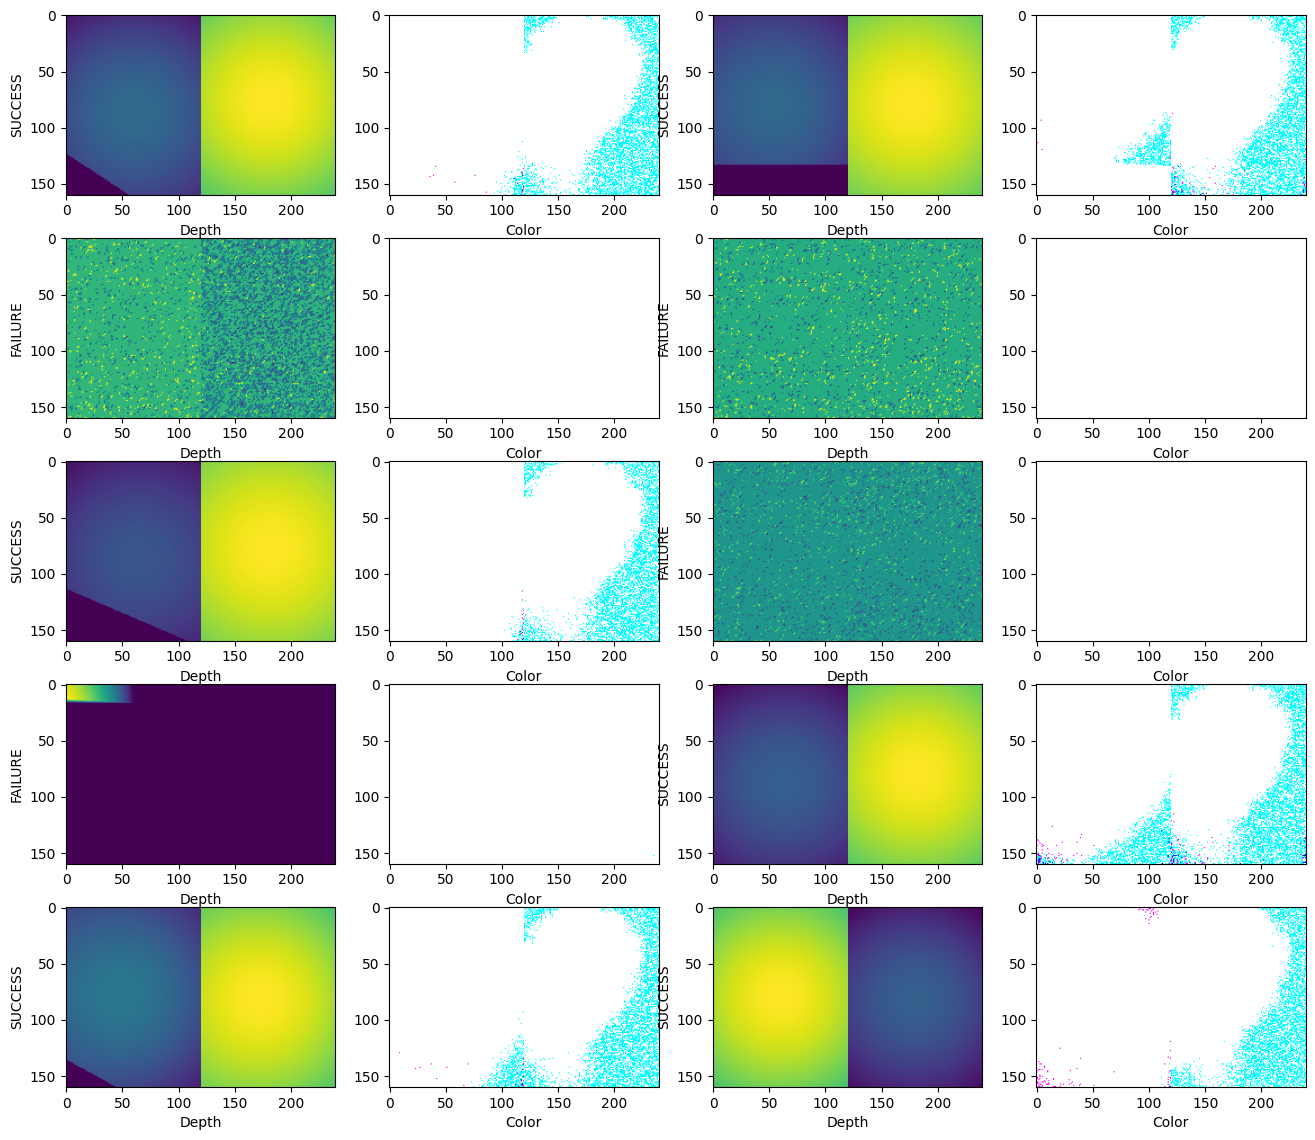

In [1038]:
rand_indices = np.random.choice(len(depth_ds), size=10)
cols = 4
rows = 5
fig = plt.figure(figsize=(16, 14))

for i in range(rows*cols):
    fig.add_subplot(rows, cols, i+1)
    if i % 2 == 0:
        plt.xlabel("Depth")
        plt.ylabel("SUCCESS" if grasp_outcomes_ds[rand_indices[i//2]].item() == 1.0 else "FAILURE")
        plt.imshow(np.array(depth_ds[rand_indices[i//2]]))
    elif i % 2 == 1:
        plt.xlabel("Color")
        plt.imshow(np.array(color_ds[rand_indices[i//2]]))
plt.show()

Plot the end effector poses to investigate if we can simply visualise a clear decision boundary between successful & unsuccessful grasps

In [1039]:
### Helper function to calculate approach vectors of a 6D pose
def calc_approach_vector(coord):
    R = np.array([[np.cos(coord[5])*np.cos(coord[4]), np.cos(coord[5])*np.sin(coord[4])*np.sin(coord[3])-np.sin(coord[5])*np.cos(coord[3]), np.cos(coord[5])*np.sin(coord[4])*np.cos(coord[3])+np.sin(coord[5])*np.sin(coord[3])],
              [np.sin(coord[5])*np.cos(coord[4]), np.sin(coord[5])*np.sin(coord[4])*np.sin(coord[3])+np.cos(coord[5])*np.cos(coord[3]), np.sin(coord[5])*np.sin(coord[4])*np.cos(coord[3])-np.cos(coord[5])*np.sin(coord[3])],
              [-np.sin(coord[4]), np.cos(coord[4])*np.sin(coord[3]), np.cos(coord[4])*np.cos(coord[3])]])
    return R.T

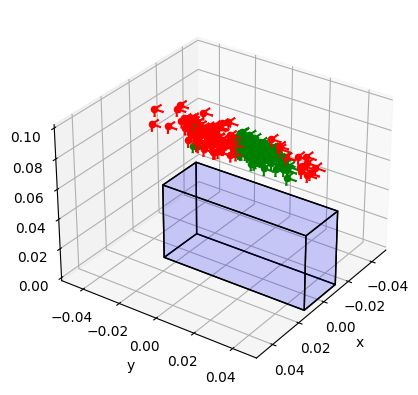

In [1040]:
plot = plt.figure()
ax = plot.add_subplot(projection='3d')
ax.axes.set_xlim3d(-0.05, 0.05)
ax.axes.set_ylim3d(-0.05, 0.05)
ax.axes.set_zlim3d(0, 0.1)


# Plot hand poses with finger skeleton
for i in range(len(poses_ds)):
    # Calculate approach vectors and cartesian coordinates
    pose = poses_ds[i]
    x, y, z = pose[0], pose[1], pose[2]
    z -= Z_PADDING * 1.65
    av = calc_approach_vector(pose)
    # Color code the outcome
    outcome = grasp_outcomes_ds[i]
    color = 'green' if outcome == 1 else 'red'
    for j in range(3):
        ax.quiver(x, y, z, av[j, 0], av[j, 1], av[j, 2], color=color, length=0.005, arrow_length_ratio=0.1)
    ax.scatter(x, y, z, color=color)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

# Draw block object
def plot_cube(cube_definition, ax):
    cube_definition_array = [np.array(list(item)) for item in cube_definition]
    points = []
    points += cube_definition_array
    vectors = [
        cube_definition_array[1] - cube_definition_array[0],
        cube_definition_array[2] - cube_definition_array[0],
        cube_definition_array[3] - cube_definition_array[0]
    ]
    points += [cube_definition_array[0] + vectors[0] + vectors[1]]
    points += [cube_definition_array[0] + vectors[0] + vectors[2]]
    points += [cube_definition_array[0] + vectors[1] + vectors[2]]
    points += [cube_definition_array[0] + vectors[0] + vectors[1] + vectors[2]]
    points = np.array(points)
    edges = [
        [points[0], points[3], points[5], points[1]],
        [points[1], points[5], points[7], points[4]],
        [points[4], points[2], points[6], points[7]],
        [points[2], points[6], points[3], points[0]],
        [points[0], points[2], points[4], points[1]],
        [points[3], points[6], points[7], points[5]]
    ]
    faces = Poly3DCollection(edges, linewidths=1, edgecolors='k')
    faces.set_facecolor((0,0,1,0.1))
    ax.add_collection3d(faces)
    # Plot the points themselves to force the scaling of the axes
    ax.scatter(points[:,0], points[:,1], points[:,2], s=0)
    # ax.set_aspect('equal')
    
# Dimensions of the block object: (W=0.025, H=0.05, D=0.05)
# (0,0,0), (0,1,0), (1,0,0), (0,0,1) -> unit cube
cube_definition = [(-0.0125, -0.025, 0), (0.0125, -0.025, 0), (-0.0125, 0.05, 0), (-0.0125, -0.025, 0.05)]
plot_cube(cube_definition, ax)

# Display the plot at different angles
ax.view_init(elev=30, azim=35, roll=0)

If the green and red points are mixed up together, it proves that there is a problem when generating the random poses.

### 4. Data Transformation/Feature Engineering for Model Training
We now train different models using different data representations and processing techniques. These include:
1. Raw data (tactile only) + LR
2. Raw data (visual only) + LR
3. Raw data (both types) + LR
4. PCA data (tactile only) + LR
5. PCA data (visual only) + LR
6. PCA data (both types) + LR
7. CNN data (tactile only) + LR
8. CNN data (visual only) + LR
9. CNN data (both types) + LR

#### Define logistic regression model

In [1041]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, data_shape: int, classes: int):
        super().__init__()
        self.linear = nn.Linear(in_features=data_shape, out_features=classes)
        init.kaiming_uniform_(self.linear.weight, nonlinearity='relu')

        self.l2_lambda = 0.01

    def forward(self, x):
        # x = x.view(x.shape[0], -1).to(torch.float32)
        x = x.reshape(x.shape[0], -1).to(torch.float32)
        x = self.linear(x)
        return x

    def train_model(self, inputs, labels, epochs, learning_rate):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.parameters(), lr=learning_rate, weight_decay=self.l2_lambda)
        inputs = inputs
        labels = labels.to(torch.float32)
        
        for epoch in range(epochs):
            # Forward pass
            outputs = self(inputs)
            loss = criterion(outputs, labels.long())

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (epoch+1) % (epochs//10) == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.2f}')
        
        print('Training completed.')

    def evaluate_model(self, inputs, labels):
        inputs = inputs.to(torch.float32)
        labels = labels.to(torch.float32)

        with torch.no_grad():
            correct = 0
            total = 0
            outputs = self(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            print(f'Accuracy of the model on the {total} test images: {100 * correct / total:.2f}%')

#### Define convolutional neural network

In [1042]:
# A simple convolutional neural network that extracts features from an input tensor
class FeatureExtractorCNN(nn.Module):
    def __init__(self):
        super(FeatureExtractorCNN, self).__init__()
        self.conv1 = nn.Conv2d(4, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.conv4 = nn.Conv2d(32, 4, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.pool2(x)

        # x = self.conv3(x)
        # x = self.pool3(x)
        
        x = self.conv4(x)
        x = nn.functional.relu(x)
        
        return x

#### Concatenate the required datasets
For this project, we require the following datasets:
- Tactile data only (concatenate the depth and color datasets) -> [N * 160 * 240 * (1+3)]
- Visual data only (end effector poses) -> [N * 6]
- Tactile and visual data -> [N * (160 * 240 * 4 + 6)]

In [1043]:
tactile_ds = torch.cat([depth_ds.unsqueeze(-1), color_ds], dim=-1)
tactile_ds = normalize(tactile_ds)
tactile_ds.shape

torch.Size([200, 160, 240, 4])

To combine the tactile and visual data, we attempt to concatenate them.

In [1044]:
complete_ds = torch.cat([tactile_ds.reshape(tactile_ds.shape[0], -1), poses_ds], dim=1)
complete_ds = normalize(complete_ds)
complete_ds.shape

torch.Size([200, 153606])

### 5. Model Training
We now train our Logistic Regression models on 3 variations of our data:
- Raw data
- Principal Component Analysis - 2 main components
- Convolutional Neural Network processed data

#### 5.1.1 Raw data (Tactile only) + LR

In [1045]:
model_5_1_1 = LogisticRegressionModel(data_shape=160*240*4, classes=2)
model_5_1_1.train_model(tactile_ds, grasp_outcomes_ds, epochs=100, learning_rate=1e-5)
model_5_1_1.evaluate_model(tactile_ds, grasp_outcomes_ds)

Epoch [10/100], Loss: 0.39
Epoch [20/100], Loss: 0.25
Epoch [30/100], Loss: 0.19
Epoch [40/100], Loss: 0.15
Epoch [50/100], Loss: 0.13
Epoch [60/100], Loss: 0.12
Epoch [70/100], Loss: 0.11
Epoch [80/100], Loss: 0.10
Epoch [90/100], Loss: 0.10
Epoch [100/100], Loss: 0.09
Training completed.
Accuracy of the model on the 200 test images: 98.50%


#### 5.1.2 Raw data (Visual only) + LR

In [1046]:
model_5_1_2 = LogisticRegressionModel(data_shape=6, classes=2)
poses_ds = normalize(poses_ds)
model_5_1_2.train_model(poses_ds, grasp_outcomes_ds, epochs=1000, learning_rate=1e-4)
model_5_1_2.evaluate_model(poses_ds, grasp_outcomes_ds)

Epoch [100/1000], Loss: 1.69
Epoch [200/1000], Loss: 1.66
Epoch [300/1000], Loss: 1.63
Epoch [400/1000], Loss: 1.60
Epoch [500/1000], Loss: 1.57
Epoch [600/1000], Loss: 1.54
Epoch [700/1000], Loss: 1.51
Epoch [800/1000], Loss: 1.49
Epoch [900/1000], Loss: 1.46
Epoch [1000/1000], Loss: 1.43
Training completed.
Accuracy of the model on the 200 test images: 50.00%


#### 5.1.3 Raw data (both data) + LR

In [1047]:
# model_5_1_3 = LogisticRegressionModel(data_shape=80*120*4+6, classes=2)
model_5_1_3 = LogisticRegressionModel(data_shape=160*240*4+6, classes=2)
model_5_1_3.train_model(complete_ds, grasp_outcomes_ds, epochs=1000, learning_rate=1e-5)
model_5_1_3.evaluate_model(complete_ds, grasp_outcomes_ds)

Epoch [100/1000], Loss: 0.09
Epoch [200/1000], Loss: 0.06
Epoch [300/1000], Loss: 0.06
Epoch [400/1000], Loss: 0.05
Epoch [500/1000], Loss: 0.05
Epoch [600/1000], Loss: 0.04
Epoch [700/1000], Loss: 0.04
Epoch [800/1000], Loss: 0.04
Epoch [900/1000], Loss: 0.04
Epoch [1000/1000], Loss: 0.03
Training completed.
Accuracy of the model on the 200 test images: 99.50%


### 5.2 Principal Component Analysis

Your system may not have enough memory to perform the PCA calculation on the entire input tensor. One solution to this issue is to perform PCA in a mini-batch fashion, where you break down the input tensor into smaller chunks and perform PCA on each chunk separately. Then, you can concatenate the results from each chunk to get the final result.

Defining a mini-batch PCA function:

In [1048]:
from sklearn.decomposition import PCA


def pca_multid(tensor, k):
    # Preprocess tensor into flattened np.array
    tensor = np.array(tensor)
    flatten_tensor = tensor.reshape(tensor.shape[0] * tensor.shape[1], tensor.shape[2])

    # Initialize sklearn pre-built PCA
    pca = PCA(n_components=k)    
    pca.fit(flatten_tensor)

    # Transform the flattened tensor using the PCA model
    transformed_tensor = pca.transform(flatten_tensor)
    
    # Reshape the transformed tensor to have shape (W*H, k)
    return transformed_tensor.reshape(tensor.shape[0], tensor.shape[1], k)

#### 5.2.1 PCA data (tactile only) + LR

We perform PCA on the tactile data only.

In [1049]:
pca_tactile_ds = torch.Tensor(np.array([pca_multid(i, k=2) for i in tactile_ds]))
pca_tactile_ds = normalize(pca_tactile_ds)
pca_tactile_ds.shape

torch.Size([200, 160, 240, 2])

Now we train a Logistic Regression model on the new PCA tactile data:

In [1050]:
# model_5_2_1 = LogisticRegressionModel(data_shape=80*120*2, classes=2)
model_5_2_1 = LogisticRegressionModel(data_shape=160*240*2, classes=2)
model_5_2_1.train_model(pca_tactile_ds, grasp_outcomes_ds, epochs=1000, learning_rate=1e-5)
model_5_2_1.evaluate_model(pca_tactile_ds, grasp_outcomes_ds)

Epoch [100/1000], Loss: 0.19
Epoch [200/1000], Loss: 0.15
Epoch [300/1000], Loss: 0.13
Epoch [400/1000], Loss: 0.12
Epoch [500/1000], Loss: 0.12
Epoch [600/1000], Loss: 0.11
Epoch [700/1000], Loss: 0.11
Epoch [800/1000], Loss: 0.11
Epoch [900/1000], Loss: 0.10
Epoch [1000/1000], Loss: 0.10
Training completed.
Accuracy of the model on the 200 test images: 97.50%


#### 5.2.2 PCA data (visual only) + LR
The dimensionality of the visual data (end effector poses) is only `N*6`, so there is no need to perform PCA on this data.

#### 5.2.3 PCA data (both data) + LR

In [1051]:
pca_complete_ds = torch.cat([pca_tactile_ds.reshape(pca_tactile_ds.shape[0], -1), poses_ds], dim=1)
pca_complete_ds = normalize(pca_complete_ds)
pca_complete_ds.shape

torch.Size([200, 76806])

In [1052]:
# model_5_2_3 = LogisticRegressionModel(data_shape=80*120*4+6, classes=2)
model_5_2_3 = LogisticRegressionModel(data_shape=160*240*2+6, classes=2)
model_5_2_3.train_model(pca_complete_ds, grasp_outcomes_ds, epochs=1000, learning_rate=1e-5)
model_5_2_3.evaluate_model(pca_complete_ds, grasp_outcomes_ds)

Epoch [100/1000], Loss: 0.19
Epoch [200/1000], Loss: 0.15
Epoch [300/1000], Loss: 0.13
Epoch [400/1000], Loss: 0.13
Epoch [500/1000], Loss: 0.12
Epoch [600/1000], Loss: 0.11
Epoch [700/1000], Loss: 0.11
Epoch [800/1000], Loss: 0.11
Epoch [900/1000], Loss: 0.10
Epoch [1000/1000], Loss: 0.10
Training completed.
Accuracy of the model on the 200 test images: 98.00%


#### 5.3.1 CNN data (tactile only) + LR

In [1053]:
# Preprocess data using CNN feature extraction
cnn_model = FeatureExtractorCNN()
cnn_output = cnn_model(tactile_ds.permute(0,3,1,2).float()).permute(0,1,2,3)
cnn_output = normalize(cnn_output)

model_5_3_1 = LogisticRegressionModel(data_shape=4*40*60, classes=2)
model_5_3_1.train_model(cnn_output.detach(), grasp_outcomes_ds, epochs=1000, learning_rate=1e-5)
model_5_3_1.evaluate_model(cnn_output, grasp_outcomes_ds)

Epoch [100/1000], Loss: 0.40
Epoch [200/1000], Loss: 0.29
Epoch [300/1000], Loss: 0.23
Epoch [400/1000], Loss: 0.20
Epoch [500/1000], Loss: 0.17
Epoch [600/1000], Loss: 0.16
Epoch [700/1000], Loss: 0.14
Epoch [800/1000], Loss: 0.14
Epoch [900/1000], Loss: 0.13
Epoch [1000/1000], Loss: 0.12
Training completed.
Accuracy of the model on the 200 test images: 96.50%


#### 5.3.2 CNN data (visual only) + LR

#### 5.3.3 CNN data (both data) + LR

In [1054]:
# We simply combine the cnn-processed tactile data (from Section 5.3.1) with the visual data
cnn_complete_ds = torch.cat([cnn_output.reshape(cnn_output.shape[0], -1), poses_ds], dim=1)
cnn_complete_ds = normalize(cnn_complete_ds)
print(cnn_complete_ds.shape)

model_5_3_3 = LogisticRegressionModel(data_shape=9606, classes=2)
model_5_3_3.train_model(cnn_complete_ds.detach(), grasp_outcomes_ds, epochs=1000, learning_rate=1e-5)
model_5_3_3.evaluate_model(cnn_complete_ds, grasp_outcomes_ds)

torch.Size([200, 9606])
Epoch [100/1000], Loss: 0.35
Epoch [200/1000], Loss: 0.26
Epoch [300/1000], Loss: 0.21
Epoch [400/1000], Loss: 0.18
Epoch [500/1000], Loss: 0.16
Epoch [600/1000], Loss: 0.14
Epoch [700/1000], Loss: 0.13
Epoch [800/1000], Loss: 0.12
Epoch [900/1000], Loss: 0.12
Epoch [1000/1000], Loss: 0.11
Training completed.
Accuracy of the model on the 200 test images: 98.00%
